# Fine-tuning a pre-trained PET-MAD universal model for specific applications

## Example 00: Basic usage of the PET-MAD model

In [41]:
import numpy as np
from ase.io import read
from tqdm import tqdm
from ase.calculators.singlepoint import SinglePointCalculator
from pet_mad.calculator import PETMADCalculator
from matplotlib import pyplot as plt

#### 1. Loading the dataset and initializing the calculator

In [13]:
DATASET_PATH = "../shared/datasets/MAD-sample/test.xyz"
dataset = read(DATASET_PATH, index=":")
calc = PETMADCalculator(device="cpu")

#### 2. Running evaluation on the dataset

In [39]:
evaluated_dataset = []
for atoms in tqdm(dataset):
    atoms = atoms.copy()
    atoms.calc = calc
    energy = atoms.get_potential_energy()
    forces = atoms.get_forces()
    singlepoint = SinglePointCalculator(atoms=atoms, energy=energy, forces=forces)
    atoms.calc = singlepoint
    evaluated_dataset.append(atoms)


100%|██████████| 50/50 [00:04<00:00, 11.91it/s]


#### 3. Plotting the predictions pairplots

In [52]:
target_energies = np.array([atoms.get_total_energy() for atoms in dataset])
predicted_energies = np.array([atoms.get_total_energy() for atoms in evaluated_dataset])
num_atoms = np.array([len(atoms) for atoms in dataset])

target_energies_per_atom = target_energies / num_atoms
predicted_energies_per_atom = predicted_energies / num_atoms

energies_mae = np.mean(np.abs(target_energies_per_atom - predicted_energies_per_atom)) * 1000 # in meV/atom

target_forces = np.concatenate([atoms.get_forces().flatten() for atoms in dataset]).flatten()
predicted_forces = np.concatenate([atoms.get_forces().flatten() for atoms in evaluated_dataset]).flatten()
forces_mae = np.mean(np.abs(target_forces - predicted_forces)) * 1000 # in meV/A

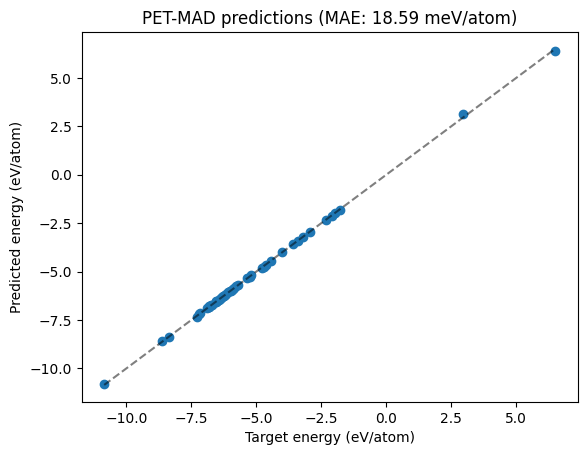

In [56]:
plt.plot(target_energies_per_atom, predicted_energies_per_atom, 'o')
plt.plot([min(target_energies_per_atom), max(target_energies_per_atom)],
         [min(target_energies_per_atom), max(target_energies_per_atom)], 'k--', alpha=0.5)
plt.xlabel("Target energy (eV/atom)")
plt.ylabel("Predicted energy (eV/atom)")
plt.title(f"PET-MAD predictions (MAE: {energies_mae:.2f} meV/atom)")
plt.show()

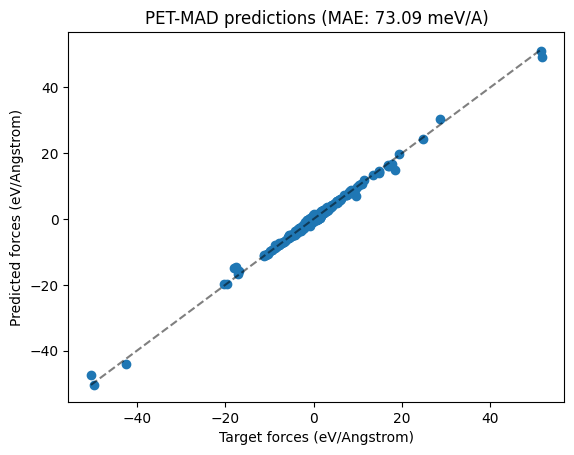

In [55]:
plt.plot(target_forces, predicted_forces, 'o')
plt.plot([min(target_forces), max(target_forces)],
         [min(target_forces), max(target_forces)], 'k--', alpha=0.5)
plt.xlabel("Target forces (eV/Angstrom)")
plt.ylabel("Predicted forces (eV/Angstrom)")
plt.title(f"PET-MAD predictions (MAE: {forces_mae:.2f} meV/A)")
plt.show()